In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN


AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

In [ ]:
df = pd.read_csv('./data/Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', encoding="latin-1", delimiter=';')
df.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [ ]:
msv = 2151264665
col = msv%12 + 1 

In [ ]:
data = df[[str(col)]]
data

,6
0,964.4
1,1019.7
2,988.4
3,1002.0
4,1061.5
...,...
360,1002.0
361,1002.0
362,1061.5
363,1022.6


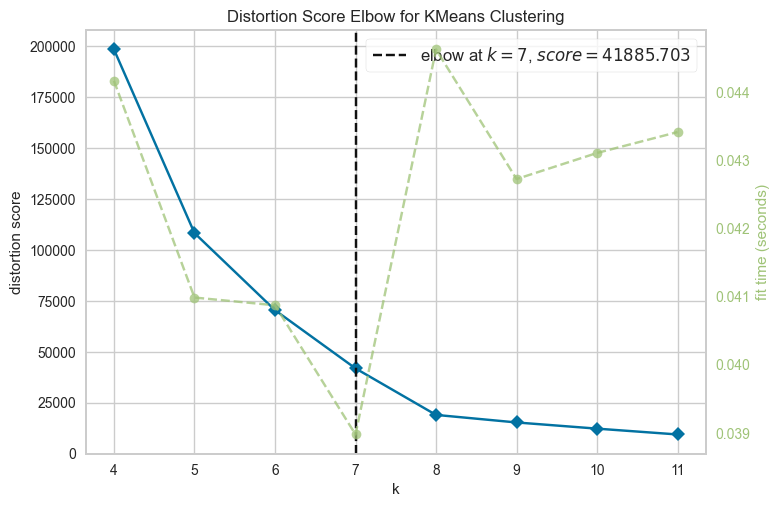

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
Elbow_M = KElbowVisualizer(KMeans(random_state=23, n_init=10), k=(4,12))
Elbow_M.fit(data)
Elbow_M.show()

# Thực hiện các model

* BayesianGaussianMixture

In [ ]:
BGM = BayesianGaussianMixture(n_components=8,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
bgm_preds = BGM.fit_predict(data)

* Gaussian

In [ ]:
GMM = GaussianMixture(n_components=8)
# fit model and predict clusters
gmm_preds = GMM.fit_predict(data)

* Kmeans

In [ ]:
Kmeans = KMeans(n_clusters=8) # Số clusters có thể điều chỉnh
# fit model and predict clusters
kmean_preds = Kmeans.fit_predict(data)

## Trainning

* BGM


In [ ]:
pp=BGM.predict_proba(data)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(data) 
df_new[[f'predict_proba_{i}' for i in range(8)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=bgm_preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [ ]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=400, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

[200]	valid_0's multi_logloss: 6.41407e-06
[400]	valid_0's multi_logloss: 6.41407e-06
[200]	valid_0's multi_logloss: 6.39422e-06
[400]	valid_0's multi_logloss: 6.39422e-06
[200]	valid_0's multi_logloss: 6.39422e-06
[400]	valid_0's multi_logloss: 6.39422e-06
[200]	valid_0's multi_logloss: 6.39422e-06
[400]	valid_0's multi_logloss: 6.39422e-06
[200]	valid_0's multi_logloss: 6.39422e-06
[400]	valid_0's multi_logloss: 6.39422e-06
[200]	valid_0's multi_logloss: 6.39422e-06
[400]	valid_0's multi_logloss: 6.39422e-06
[200]	valid_0's multi_logloss: 6.26776e-06
[400]	valid_0's multi_logloss: 6.26776e-06
[200]	valid_0's multi_logloss: 6.84467e-06
[400]	valid_0's multi_logloss: 6.84467e-06
[200]	valid_0's multi_logloss: 6.46594e-06
[400]	valid_0's multi_logloss: 6.46594e-06
[200]	valid_0's multi_logloss: 6.46594e-06
[400]	valid_0's multi_logloss: 6.46594e-06
[200]	valid_0's multi_logloss: 6.46594e-06
[400]	valid_0's multi_logloss: 6.46594e-06


In [ ]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new)

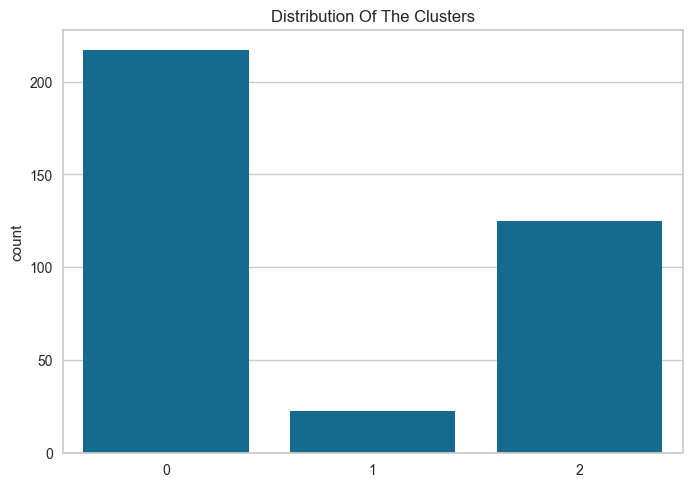

In [ ]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

* GMM


In [ ]:
pp=GMM.predict_proba(data)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(data) 
df_new[[f'predict_proba_{i}' for i in range(8)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=gmm_preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [ ]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=400, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=11.
  warnings.warn(


[200]	valid_0's multi_logloss: 1.70708e-05
[400]	valid_0's multi_logloss: 1.70708e-05
[200]	valid_0's multi_logloss: 1.65617e-05
[400]	valid_0's multi_logloss: 1.65617e-05
[200]	valid_0's multi_logloss: 1.55397e-05
[400]	valid_0's multi_logloss: 1.55397e-05
[200]	valid_0's multi_logloss: 1.63005e-05
[400]	valid_0's multi_logloss: 1.63005e-05
[200]	valid_0's multi_logloss: 1.67127e-05
[400]	valid_0's multi_logloss: 1.67127e-05
[200]	valid_0's multi_logloss: 1.62425e-05
[400]	valid_0's multi_logloss: 1.62425e-05
[200]	valid_0's multi_logloss: 1.64326e-05
[400]	valid_0's multi_logloss: 1.64326e-05
[200]	valid_0's multi_logloss: 0.0723699
[400]	valid_0's multi_logloss: 0.0723699
[200]	valid_0's multi_logloss: 1.28212e-05
[400]	valid_0's multi_logloss: 1.28212e-05
[200]	valid_0's multi_logloss: 1.6295e-05
[400]	valid_0's multi_logloss: 1.6295e-05
[200]	valid_0's multi_logloss: 1.61558e-05
[400]	valid_0's multi_logloss: 1.61558e-05


In [ ]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new)

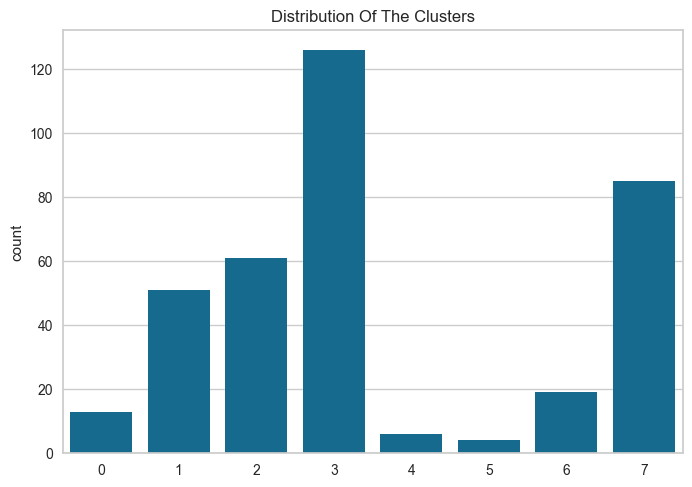

In [ ]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

* Kmeans


In [ ]:
pp=Kmeans.predict_proba(data)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(data) 
df_new[[f'predict_proba_{i}' for i in range(8)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=bgm_preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

AttributeError: 'KMeans' object has no attribute 'predict_proba'

In [ ]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=400, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

In [ ]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new)

In [ ]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()